<a id='start'></a>
# Decision Tree Esercizi

In questo notebook vengono presentati degli esercizi sui Decision Tree. <br>
Provate a svolgere il seguente esercizio: <br>
1) [Sopravvivere all'iceberg](#section1)<br>
2) [Predire il diabete](#section2)

<a id='section1'></a>
## Sopravvivere all'iceberg

Torniamo ad analizzare i dati dei passeggeri del Titanic. Proviamo a vedere se è possibile realizzare un albero di decisione che ci permetta di discernere chi è morto da chi è sopravvissuto:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

train = pd.read_csv("data/train_dataset_titanic.csv")
train.head()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
import numpy as np
import time
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

Codifichiamo il sesso come variabile binaria:

In [3]:
train.Sex = train.Sex.map({'female': 1, 'male': 0})
train.Embarked = train.Embarked.map({'C': 0, 'Q': 1, 'S': 2})
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,2.0


In [4]:
feature_names = pd.Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

for col in feature_names:
    c = train[col].isna().sum()
    print("Column %s has %d N/A." % (col, c))

Column Pclass has 0 N/A.
Column Sex has 0 N/A.
Column Age has 177 N/A.
Column SibSp has 0 N/A.
Column Parch has 0 N/A.
Column Fare has 0 N/A.
Column Embarked has 2 N/A.


Utilizziamo la classe [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) di sklearn per modificare i dati non esistenti:

In [6]:
imp = SimpleImputer(strategy='mean')
for col in feature_names:
    print("%s" %imp.fit_transform(train[col].values))
    

ValueError: Expected 2D array, got 1D array instead:
array=[3. 1. 3. 1. 3. 3. 1. 3. 3. 2. 3. 1. 3. 3. 3. 2. 3. 2. 3. 3. 2. 2. 3. 1.
 3. 3. 3. 1. 3. 3. 1. 1. 3. 2. 1. 1. 3. 3. 3. 3. 3. 2. 3. 2. 3. 3. 3. 3.
 3. 3. 3. 3. 1. 2. 1. 1. 2. 3. 2. 3. 3. 1. 1. 3. 1. 3. 2. 3. 3. 3. 2. 3.
 2. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 1. 2. 3. 3. 3. 1. 3. 3. 3. 1. 3. 3. 3.
 1. 1. 2. 2. 3. 3. 1. 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 3. 2. 1. 3.
 2. 3. 2. 2. 1. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 1. 1. 3. 1. 3. 3. 3. 3.
 2. 2. 3. 3. 2. 2. 2. 1. 3. 3. 3. 1. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 1. 3.
 1. 3. 1. 3. 3. 3. 1. 3. 3. 1. 2. 3. 3. 2. 3. 2. 3. 1. 3. 1. 3. 3. 2. 2.
 3. 2. 1. 1. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 3. 2. 3. 2. 3. 1.
 3. 2. 1. 2. 3. 2. 3. 3. 1. 3. 2. 3. 2. 3. 1. 3. 2. 3. 2. 3. 2. 2. 2. 2.
 3. 3. 2. 3. 3. 1. 3. 2. 1. 2. 3. 3. 1. 3. 3. 3. 1. 1. 1. 2. 3. 3. 1. 1.
 3. 2. 3. 3. 1. 1. 1. 3. 2. 1. 3. 1. 3. 2. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3.
 2. 3. 1. 1. 2. 3. 3. 1. 3. 1. 1. 1. 3. 3. 3. 2. 3. 1. 1. 1. 2. 1. 1. 1.
 2. 3. 2. 3. 2. 2. 1. 1. 3. 3. 2. 2. 3. 1. 3. 2. 3. 1. 3. 1. 1. 3. 1. 3.
 1. 1. 3. 1. 2. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 1. 3. 3. 3. 3. 1. 2. 3. 3.
 3. 2. 3. 3. 3. 3. 1. 3. 3. 1. 1. 3. 3. 1. 3. 1. 3. 1. 3. 3. 1. 3. 3. 1.
 3. 2. 3. 2. 3. 2. 1. 3. 3. 1. 3. 3. 3. 2. 2. 2. 3. 3. 3. 3. 3. 2. 3. 2.
 3. 3. 3. 3. 1. 2. 3. 3. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 2. 2. 3. 3. 1. 3.
 2. 3. 1. 1. 3. 2. 1. 2. 2. 3. 3. 2. 3. 1. 2. 1. 3. 1. 2. 3. 1. 1. 3. 3.
 1. 1. 2. 3. 1. 3. 1. 2. 3. 3. 2. 1. 3. 3. 3. 3. 2. 2. 3. 1. 2. 3. 3. 3.
 3. 2. 3. 3. 1. 3. 1. 1. 3. 3. 3. 3. 1. 1. 3. 3. 1. 3. 1. 3. 3. 3. 3. 3.
 1. 1. 2. 1. 3. 3. 3. 3. 1. 1. 3. 1. 2. 3. 2. 3. 1. 3. 3. 1. 3. 3. 2. 1.
 3. 2. 2. 3. 3. 3. 3. 2. 1. 1. 3. 1. 1. 3. 3. 2. 1. 1. 2. 2. 3. 2. 1. 2.
 3. 3. 3. 1. 1. 1. 1. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 2. 1. 1. 3. 3. 3.
 2. 1. 3. 3. 2. 1. 2. 1. 3. 1. 2. 1. 3. 3. 3. 1. 3. 3. 2. 3. 2. 3. 3. 1.
 2. 3. 1. 3. 1. 3. 3. 1. 2. 1. 3. 3. 3. 3. 3. 2. 3. 3. 2. 2. 3. 1. 3. 3.
 3. 1. 2. 1. 3. 3. 1. 3. 1. 1. 3. 2. 3. 2. 3. 3. 3. 1. 3. 3. 3. 1. 3. 1.
 3. 3. 3. 2. 3. 3. 3. 2. 3. 3. 2. 1. 1. 3. 1. 3. 3. 2. 2. 3. 3. 1. 2. 1.
 2. 2. 2. 3. 3. 3. 3. 1. 3. 1. 3. 3. 2. 2. 3. 3. 3. 1. 1. 3. 3. 3. 1. 2.
 3. 3. 1. 3. 1. 1. 3. 3. 3. 2. 2. 1. 1. 3. 1. 1. 1. 3. 2. 3. 1. 2. 3. 3.
 2. 3. 2. 2. 1. 3. 2. 3. 2. 3. 1. 3. 2. 2. 2. 3. 3. 1. 3. 3. 1. 1. 1. 3.
 3. 1. 3. 2. 1. 3. 2. 3. 3. 3. 2. 2. 3. 2. 3. 1. 3. 3. 3. 1. 3. 1. 1. 3.
 3. 3. 3. 3. 2. 3. 2. 3. 3. 3. 3. 1. 3. 1. 1. 3. 3. 3. 3. 3. 3. 1. 3. 2.
 3. 1. 3. 2. 1. 3. 3. 3. 2. 2. 1. 3. 3. 3. 1. 3. 2. 1. 3. 3. 2. 3. 3. 1.
 3. 2. 3. 3. 1. 3. 1. 3. 3. 3. 3. 2. 3. 1. 3. 2. 3. 3. 3. 1. 3. 3. 3. 1.
 3. 2. 1. 3. 3. 3. 3. 3. 2. 1. 3. 3. 3. 1. 2. 3. 1. 1. 3. 3. 3. 2. 1. 3.
 2. 2. 2. 1. 3. 3. 3. 1. 1. 3. 2. 3. 3. 3. 3. 1. 2. 3. 3. 2. 3. 3. 2. 1.
 3. 1. 3.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [27]:
imp = SimpleImputer(strategy='mean')

for col in feature_names:
    train[col] = imp.fit_transform(train[col].values.reshape(-1, 1))
    
for col in feature_names:
    c = train[col].isna().sum()
    print("Column %s has %d N/A." % (col, c))

Column Pclass has 0 N/A.
Column Sex has 0 N/A.
Column Age has 0 N/A.
Column SibSp has 0 N/A.
Column Parch has 0 N/A.
Column Fare has 0 N/A.
Column Embarked has 0 N/A.


Dividiamo i dati tra training e test:

In [28]:
train['Survived'] = train.Survived.astype('category')

X = train[feature_names]
X = pd.get_dummies(X, columns=X.columns)
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Facciamo la classificazione con il decision tree:

In [29]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

tree.export_graphviz(clf,
                     out_file='out/titanic_file.dot',
                     impurity=False,
                     feature_names=X_test.columns.values,
                     class_names=['No', 'Yes'],
                     rounded=True,
                     filled=True)

Ecco l'albero disegnato con [WebGraphViz](http://webgraphviz.com/):

<img src="img/titanic_tree.png?id=3">

Proviamo ora a usare XGBoost per predire all'imbarco la probabilità di morte al momento dell'incidente.

Il dataset è così descritto:
- survival - Survival (0 = No; 1 = Yes)
- class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of Siblings/Spouses Aboard
- parch - Number of Parents/Children Aboard
- ticket - Ticket Number
- fare - Passenger Fare
- cabin - Cabin
- embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

Possiamo quindi cercare di prevedere 'survival' partendo da 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'.

Tutte le label sono già numeriche tranne Sex e Embarked, che trasformiamo.

In [30]:
xgbtrain = xgb.DMatrix(data=train[feature_names],
                       label=train.Survived.cat.codes,
                       feature_names=feature_names)

param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

booster = xgb.train(param, xgbtrain, num_boost_round=num_trees)
predictions = booster.predict(xgbtrain)

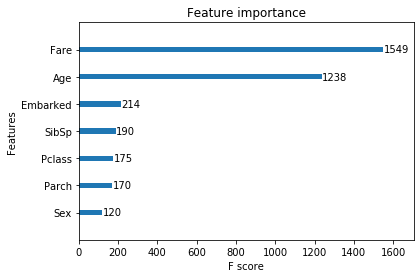

In [31]:
xgb.plot_importance(booster, grid=False)
plt.show()

In [32]:
d = train.copy()

d['prediction'] = np.around(booster.predict(xgbtrain)).astype('int64')
d[['prediction', 'Survived']]

,prediction,Survived
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
...,...,...
886,0,0
887,1,1
888,0,0
889,1,1


In [33]:
right = d.loc[d['prediction'] == d['Survived']]
wrong = d.loc[d['prediction'] != d['Survived']]

true_positive = right.loc[right['prediction'] == 1]
false_positive = wrong.loc[wrong['prediction'] == 1]
false_negative = wrong.loc[wrong['prediction'] == 0]

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))

We had 891 elements in our recordset.
We classified correctly 844 events.
We classified wrongly 47 events.
We had 12 false positive and 35 false negative.

Our precision has been 0.96.
Our recall has been 0.90.


<a id='section2'></a>
## Predire il diabete

Utilizziamo il dataset `pima-indians-diabetes.data.csv` per provare a predire l'insorgenza di diabete nei pazienti in esso decritti.

In [43]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('data/pima-indians-diabetes.csv')
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetePedigreeFunction,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Andiamo a rappresentare il decision tree per vedere come vengono prese in considerazioni le features:

In [46]:
y = dataset[['Class']].copy()
y['Class'] = y.Class.astype('category')

X = dataset.drop(['Class'], axis=1)
X = pd.get_dummies(X, columns=X.columns)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

dct = tree.DecisionTreeClassifier(max_depth=3)
dct.fit(X_train, y_train)
score = dct.score(X_test, y_test)
print("High-Dimensionality Score:", score)

# With the following sintax we will create a .dot file with the code for visualizing th tree
tree.export_graphviz(dct,
                     out_file='out/diabetes-tree.dot',
                     feature_names=X.columns,
                     filled=True,
                     leaves_parallel=True
                    )

High-Dimensionality Score: 0.6320346320346321


<img src="img/diabetes.png">

Passiamo ora a usare il metodo dei boosted decision tree:

In [55]:
feature_names = dataset.columns.tolist()
feature_names.remove('Class')

dataset['Class'] = dataset.Class.astype('category')

train = xgb.DMatrix(data=dataset[feature_names],
                    label=dataset.Class.cat.codes,
                    feature_names=feature_names)

In [56]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

booster = xgb.train(param, train, num_boost_round=num_trees)
predictions = booster.predict(train)

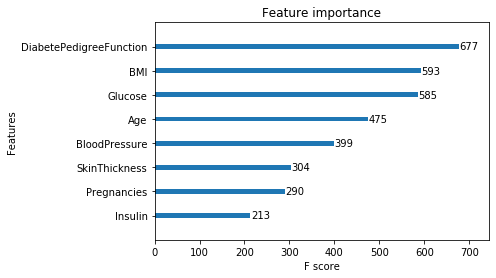

In [57]:
xgb.plot_importance(booster, grid=False)
plt.show()

In [58]:
d = dataset.copy()

d['prediction'] = np.around(booster.predict(train)).astype('int64')
d[['prediction', 'Class']]

,prediction,Class
0,1,1
1,0,0
2,1,1
3,0,0
4,1,1
...,...,...
763,0,0
764,0,0
765,0,0
766,1,1


In [60]:
right = d.loc[d['prediction'] == d['Class']]
wrong = d.loc[d['prediction'] != d['Class']]

true_positive = right.loc[right['prediction'] == 's']
false_positive = wrong.loc[wrong['prediction'] == 's']
false_negative = wrong.loc[wrong['prediction'] == 'd']

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

We had 768 elements in our recordset.
We classified correctly 767 events.
We classified wrongly 1 events.
We had 0 false positive and 0 false negative.


[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>